In [14]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import shutil
import time

from datetime import datetime
from itertools import product
from scipy.spatial.distance import cdist
from shapely import Point, LineString
!install geopy
from geopy.distance import geodesic
from shapely.strtree import STRtree
from sklearn.cluster import DBSCAN

^C
Enter the absolute path where the nvm-windows zip file is extracted/copied to: 


ModuleNotFoundError: No module named 'geopy'

In [15]:
#getting the cozie data
base_dir = 'D:/Desktop/MSc Thesis - Copy/'
cozie_df = pd.read_csv(os.path.join(base_dir, 'Data/Participant data/arda_survey_results_select_en.csv'), header = 0)
cozie_df.drop('Unnamed: 0', axis=1, inplace=True)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [7]:
# removing columns that are not needed
cozie_df.drop(['si_iphone_location_service_enabled', 'si_watch_location_service_enabled', 'ts_location_acquisition_method',
                  'ts_location_floor', 'ts_location_source_device', 'ws_location_acquisition_method', 'ws_location_floor',
                  'ws_location_source_device', 'wss_goal', 'wss_participation_days', 'wss_participation_time_end', 
                  'wss_participation_time_start', 'wss_reminder_enabeled', 'wss_reminder_interval', 'ts_HRV', 'ts_audio_exposure_environment', 
                  'ts_audio_exposure_headphones', 'ts_heart_rate', 'ts_oxygen_saturation', 'ts_resting_heart_rate', 'ts_sleep_REM', 'ts_sleep_awake',
                  'ts_sleep_core', 'ts_sleep_deep', 'ts_sleep_in_bed', 'ts_sleep_unspecified', 'ts_stand_time', 'ts_step_count', 'ts_walking_distance',
                  'ws_HRV', 'ws_audio_exposure_environment', 'ws_audio_exposure_headphones', 'ws_heart_rate', 'ws_oxygen_saturation', 
                  'ws_resting_heart_rate', 'ws_sleep_REM', 'ws_sleep_awake', 'ws_sleep_core', 'ws_sleep_deep', 'ws_sleep_in_bed', 'ws_sleep_unspecified',
                  'ws_stand_time', 'ws_step_count', 'ws_walking_distance', 'wss_time_out'], axis=1, inplace=True)

# removing additional columns that (should) not be needed
cozie_df.drop(['q_clothing', 'q_mood', ], axis=1, inplace=True)

print(cozie_df.columns) #printing column names

Index(['id_participant', 'location_change', 'q_activity_change_leisure',
       'q_activity_change_meal', 'q_activity_change_other',
       'q_activity_change_outdoors', 'q_activity_change_studying',
       'q_activity_change_working', 'q_activity_indoors',
       'q_activity_outdoors', 'q_adaptive_comfort', 'q_location',
       'q_location_change', 'q_location_leisure', 'q_location_meal',
       'q_location_other', 'q_location_studying', 'q_location_working',
       'q_thermal', 'timestamp', 'ts_altitude', 'ts_latitude',
       'ts_location_accuracy_horizontal', 'ts_location_accuracy_vertical',
       'ts_longitude', 'ts_timestamp_location', 'ws_altitude', 'ws_latitude',
       'ws_location_accuracy_horizontal', 'ws_location_accuracy_vertical',
       'ws_longitude', 'ws_survey_count', 'ws_timestamp_location',
       'ws_timestamp_start', 'wss_title'],
      dtype='object')


In [8]:
# replacing 0.0 coordinate value with NaN
cozie_df[['ts_longitude', 'ws_longitude', 'ts_latitude', 'ws_latitude']] = cozie_df[['ts_longitude', 'ws_longitude', 'ts_latitude', 'ws_latitude']].astype(float)
cozie_df[['ts_longitude', 'ws_longitude', 'ts_latitude', 'ws_latitude']] = cozie_df[['ts_longitude', 'ws_longitude', 'ts_latitude', 'ws_latitude']].replace({0: np.nan})

In [9]:
# dealing with timestamps
cozie_df['datetime'] = pd.to_datetime(cozie_df.timestamp, format='ISO8601')
cozie_df['date'] = cozie_df['datetime'].dt.date

cozie_df['datetime_ts_location'] = pd.to_datetime(cozie_df.ts_timestamp_location, format='ISO8601')
cozie_df['datetime_ws_location'] = pd.to_datetime(cozie_df.ws_timestamp_location, format='ISO8601')

cozie_df['merged_datetime'] = cozie_df['datetime_ts_location'].combine_first(cozie_df['datetime_ws_location'])
cozie_df['merged_date'] = cozie_df['merged_datetime'].dt.date

In [10]:
# dropping rows that are not needed 

# drop the Weather (short) wss title value
cozie_df.drop(cozie_df.loc[cozie_df.wss_title == 'Weather (short)'].index, inplace=True)

# drop rows with all null values
cozie_df = cozie_df.loc[cozie_df[
    ['location_change', 'q_activity_change_leisure', 'q_activity_change_meal', 'q_activity_change_other', 'q_activity_change_outdoors',
     'q_activity_change_studying', 'q_activity_change_working', 'q_activity_indoors', 'q_activity_outdoors', 'q_adaptive_comfort',
     'q_location', 'q_location_change', 'q_location_leisure', 'q_location_meal', 'q_location_other', 'q_location_studying',
     'q_location_working', 'q_thermal', 'ts_altitude', 'ts_latitude', 'ts_location_accuracy_horizontal', 'ts_location_accuracy_vertical', 
     'ts_longitude', 'ts_timestamp_location', 'ws_altitude', 'ws_latitude', 'ws_location_accuracy_horizontal', 'ws_location_accuracy_vertical', 
     'ws_longitude', 'ws_survey_count', 'ws_timestamp_location', 'ws_timestamp_start']].dropna(how='all').index].reset_index(drop=True)

# drop rows with no coordinates AND no Cozie survey
cozie_df = cozie_df.loc[cozie_df[
    ['q_activity_change_leisure', 'q_activity_change_meal', 'q_activity_change_other', 'q_activity_change_outdoors',
     'q_activity_change_studying', 'q_activity_change_working', 'q_activity_indoors', 'q_activity_outdoors', 'q_adaptive_comfort',
     'q_location', 'q_location_change', 'q_location_leisure', 'q_location_meal', 'q_location_other', 'q_location_studying',
     'q_location_working', 'q_thermal', 'ts_latitude', 'ts_longitude', 'ws_latitude', 'ws_longitude']].dropna(how='all').index] \
    .reset_index(drop=True)

# drop rows with no coordinates
cozie_df = cozie_df.loc[cozie_df[
    [ 'ts_latitude', 'ts_longitude', 'ws_latitude', 'ws_longitude']].dropna(how='all').index] \
    .reset_index(drop=True)

In [11]:
# creating new fields

# combining ts and ws latitude and longitude into new coordinate columns
cozie_df['latitude'] = np.where(cozie_df['ts_latitude'].notna(), cozie_df['ts_latitude'], cozie_df['ws_latitude'])
cozie_df['longitude'] = np.where(cozie_df['ts_longitude'].notna(), cozie_df['ts_longitude'], cozie_df['ws_longitude'])

cozie_df['latitude'] = cozie_df['latitude'].astype(float)
cozie_df['longitude'] = cozie_df['longitude'].astype(float)

# field for ws/ts coordinate source
cozie_df['coordinate_source'] = np.where(cozie_df['ts_latitude'].notna(), 'ts', 'ws')
cozie_df['source_change'] = cozie_df['coordinate_source'] == cozie_df['coordinate_source'].shift()

# dataset time range fields
start_date = cozie_df['date'].min()
end_date = cozie_df['date'].max()
total_weeks = (end_date - start_date).days  # number of complete weeks
unique_months = cozie_df['merged_datetime'].dt.strftime('%Y-%m').unique()

# single field with a location value
cozie_df['location'] = cozie_df[
    ['q_location_leisure', 'q_location_meal', 'q_location_other', 'q_location_studying', 'q_location_working']
].apply(lambda row: row.dropna().iloc[0] if not row.dropna().empty else None, axis=1)

In [12]:
# some basic information about the raw data:
print(f'Number of records: {cozie_df.shape[0]}') 
print(f"Data spans {(end_date - start_date).days} days from {start_date} to {end_date}")
print(f"Total weeks covered: {total_weeks}")
print(f"Months covered: {', '.join(unique_months)}")

Number of records: 54322
Data spans 51 days from 2023-10-04 to 2023-11-24
Total weeks covered: 51
Months covered: 2023-10, 2023-11


# __Dataset Cleaning__

### Filtering 1: removing reduntant rows

In [13]:
# keeping only the non-reduntant coordinate information
# rows are deemed non-redunant if enough time (time threshold) has passed since the last record from the same participant 

cozie_df = cozie_df.sort_values(by=['id_participant', 'merged_datetime'])
time_threshold = pd.Timedelta(seconds=60)

# defining a few fields to compare each coord with its previous one
cozie_df['prev_lat'] = cozie_df.groupby('id_participant')['latitude'].shift()
cozie_df['prev_lon'] = cozie_df.groupby('id_participant')['longitude'].shift()
cozie_df['prev_time'] = cozie_df.groupby('id_participant')['merged_datetime'].shift()
cozie_df['time_diff'] = (cozie_df['merged_datetime'] - cozie_df['prev_time']).dt.total_seconds()
cozie_df['geo_distance'] = cozie_df.apply(
    lambda row: geodesic((row['latitude'], row['longitude']), 
                         (row['prev_lat'], row['prev_lon'])
                        ).meters if pd.notnull(row['prev_lat']) and pd.notnull(row['prev_lon']) else 0,
    axis=1
)

# identify non-redundant rows
non_redundant_df = cozie_df[
    (cozie_df['id_participant'] != cozie_df['id_participant'].shift()) |            # keep first occurrence per participant
    (cozie_df['merged_datetime'].sub(cozie_df['merged_datetime'].shift()).abs() > time_threshold) # keep rows outside threshold
].copy()

print(f"Total rows before filtering 1: {len(cozie_df)}")
print(f"Total distinct positions (after removing redundant ones): {len(non_redundant_df)}")

NameError: name 'geodesic' is not defined

In [ ]:
# re-calculating the previous-coordinate fields after keeping only non-redundant rows
non_redundant_df['prev_lat'] = non_redundant_df.groupby('id_participant')['latitude'].shift()
non_redundant_df['prev_lon'] = non_redundant_df.groupby('id_participant')['longitude'].shift()
non_redundant_df['prev_time'] = non_redundant_df.groupby('id_participant')['merged_datetime'].shift()
non_redundant_df['time_diff'] = (non_redundant_df['merged_datetime'] - non_redundant_df['prev_time']).dt.total_seconds()
non_redundant_df['geo_distance'] = non_redundant_df.apply(
    lambda row: geodesic((row['latitude'], row['longitude']), 
                         (row['prev_lat'], row['prev_lon'])
                        ).meters if pd.notnull(row['prev_lat']) and pd.notnull(row['prev_lon']) else 0,
    axis=1
)

### Filtering 2: Removing positions with no change in coordinates

In [ ]:
# records where the coordinates are IDENTICAL to the previous record, but with a location change being indicated are removed
non_redundant_df['same_coordinates'] = (non_redundant_df['latitude'] == non_redundant_df['prev_lat']) & \
                                       (non_redundant_df['longitude'] == non_redundant_df['prev_lon'])

# conditions for removal
conditions = (
    (non_redundant_df['same_coordinates']) &
    ((non_redundant_df['q_location_change'].isin(['Yes, less than 15 min', 'Yes, less than 30 min', 'Yes, less than 45 min', 'Yes, more than 40 min'])) |
        (non_redundant_df['location_change'] == True))
)

filtered_df = non_redundant_df[conditions == False]

# Drop the temporary 'same_coordinates' column
filtered_df = filtered_df.drop(columns=['same_coordinates'])

# Print the number of records before and after filtering
print(f"Number of records before filtering 2: {len(non_redundant_df)}")
print(f"Number of records after filtering 2: {len(filtered_df)}")
print(f"Total deleted rows by filtering 2: {len(non_redundant_df) - len(filtered_df)}")

Number of records before filtering 2: 15922
Number of records after filtering 2: 15879
Total deleted rows by filtering 2: 43


In [ ]:
filtered_df['prev_lat'] = filtered_df.groupby('id_participant')['latitude'].shift()
filtered_df['prev_lon'] = filtered_df.groupby('id_participant')['longitude'].shift()
filtered_df['prev_time'] = filtered_df.groupby('id_participant')['merged_datetime'].shift()
filtered_df['time_diff'] = (filtered_df['merged_datetime'] - filtered_df['prev_time']).dt.total_seconds()
filtered_df['geo_distance'] = filtered_df.apply(
    lambda row: geodesic((row['latitude'], row['longitude']), 
                         (row['prev_lat'], row['prev_lon'])
                        ).meters if pd.notnull(row['prev_lat']) and pd.notnull(row['prev_lon']) else 0,
    axis=1
)

### Filtering 3

In [ ]:
# getting the coordinates and timestamp of next location
filtered_df['next_lat'] = filtered_df.groupby('id_participant')['latitude'].shift(-1)
filtered_df['next_lon'] = filtered_df.groupby('id_participant')['longitude'].shift(-1)
filtered_df['next_time'] = filtered_df.groupby('id_participant')['merged_datetime'].shift(-1)

# distance from current to next location
filtered_df['next_geo_distance'] = filtered_df.groupby('id_participant')['geo_distance'].shift(-1)

# distance from previous to next location
filtered_df['prev_next_geo_distance'] = filtered_df.apply(
    lambda row: geodesic((row['prev_lat'], row['prev_lon']),
                         (row['next_lat'], row['next_lon'])).meters
    if pd.notnull(row['prev_lat']) and pd.notnull(row['prev_lon']) and 
       pd.notnull(row['next_lat']) and pd.notnull(row['next_lon']) else 0, axis=1
)

In [ ]:
# computing the Basic Distance Ratio between the three points (previous, current, next)

filtered_df['distance_ratio'] = filtered_df['prev_next_geo_distance'] / (filtered_df['geo_distance'] + filtered_df['next_geo_distance'])
filtered_df['distance_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
filtered_df['distance_ratio'].fillna(0, inplace=True)

# implementing a time-scaling factor
filtered_df['next_time_diff'] = filtered_df.groupby('id_participant')['time_diff'].shift(-1)
filtered_df['max_time_diff'] = filtered_df[['time_diff', 'next_time_diff']].max(axis=1)
filtered_df['time_weight'] = 1 / (1 + np.log1p(filtered_df['max_time_diff']/60)) # time weight function in minutes (not seconds)

filtered_df['adjusted_distance_ratio'] = (
    filtered_df['distance_ratio'] * filtered_df['time_weight']
)


C:\Users\Michele\AppData\Local\Temp\ipykernel_19136\2535898079.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_df['distance_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\Michele\AppData\Local\Temp\ipykernel_19136\2535898079.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

In [ ]:
# calculating the speed from last location
non_redundant_df['speed'] = non_redundant_df['geo_distance'] / non_redundant_df['time_diff']
non_redundant_df['speed'].replace([float('inf'), -float('inf')], pd.NA, inplace=True)   # replacing infinite speeds with NaN (first point of each participant)

cozie_df['speed'] = cozie_df['geo_distance'] / cozie_df['time_diff']
cozie_df['speed'].replace([float('inf'), -float('inf')], pd.NA, inplace=True)      

filtered_df['speed'] = filtered_df['geo_distance'] / filtered_df['time_diff']
filtered_df['speed'].replace([float('inf'), -float('inf')], pd.NA, inplace=True)      # replacing infinite speeds with NaN (first point of each participant)

C:\Users\Michele\AppData\Local\Temp\ipykernel_12380\870664282.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  non_redundant_df['speed'].replace([float('inf'), -float('inf')], pd.NA, inplace=True)   # replacing infinite speeds with NaN (first point of each participant)
C:\Users\Michele\AppData\Local\Temp\ipykernel_12380\870664282.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method w

# __Grouping Positions into Nodes__

In [ ]:
# import the building footprints 
buildings = gpd.read_file(os.path.join(base_dir, 'Data/GIS data/Building footprints/footprint_shapefile/Z_F_merge/merge_valid.shp'))

In [ ]:
#  importing Seoul's extents
extents_gdf = gpd.read_file(os.path.join(base_dir, 'Data/Extents/Seoul extents/seoul_extents.shp'))
print(extents_gdf.crs) 

extents_gdf = extents_gdf.to_crs(buildings.crs)

print(extents_gdf.crs) 

EPSG:4326
EPSG:5174


In [ ]:
extents_gdf["is_valid"] = extents_gdf.is_valid

In [ ]:
# creating a GeoDataFrame from the filtered points
positions_gdf = gpd.GeoDataFrame(filtered_df, geometry=gpd.points_from_xy(filtered_df.longitude, filtered_df.latitude), crs='EPSG:4326')
positions_gdf = positions_gdf.to_crs(buildings.crs)

In [ ]:
# marking positions that are outside Seoul's extents
# initializing the node id field
positions_gdf['node_id'] = np.nan

# function to check if a point is inside the extents
positions_gdf["in_Seoul"] = positions_gdf.geometry.within(extents_gdf.union_all())

# storing the records of when participants go outside the shape
outside_records = []

for participant_id, group in positions_gdf.groupby('id_participant'):
    outside = False
    last_outside_time = None
    
    for idx, row in group.iterrows():
        if not row['in_Seoul']:
            if not outside:
                # record the first time the participant goes outside the shape
                row['node_id'] = 1
                outside_records.append(row)
                outside = True
                last_outside_time = row['merged_datetime']
            elif (row['merged_datetime'] - last_outside_time).total_seconds() >= 3600:
                # record if the participant remains outside the shape more than one hour
                row['node_id'] = 1
                outside_records.append(row)
                last_outside_time = row['merged_datetime']
        else:
            outside = False

# Convert the list of records to a dataframe
outside_records_df = pd.DataFrame(outside_records)

In [ ]:
print('Max id:', positions_gdf["node_id"].max())
print('Number of node ids:', len(positions_gdf["node_id"].unique()))

Max id: nan
Number of node ids: 1


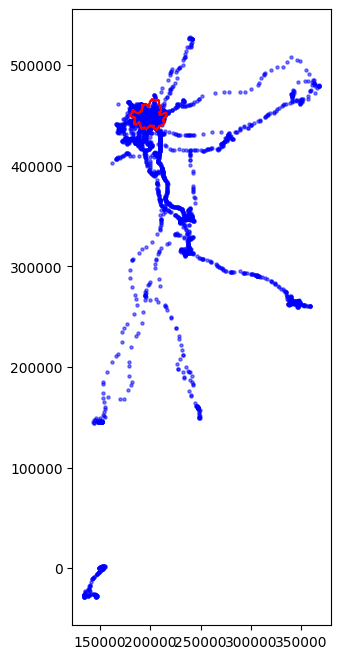

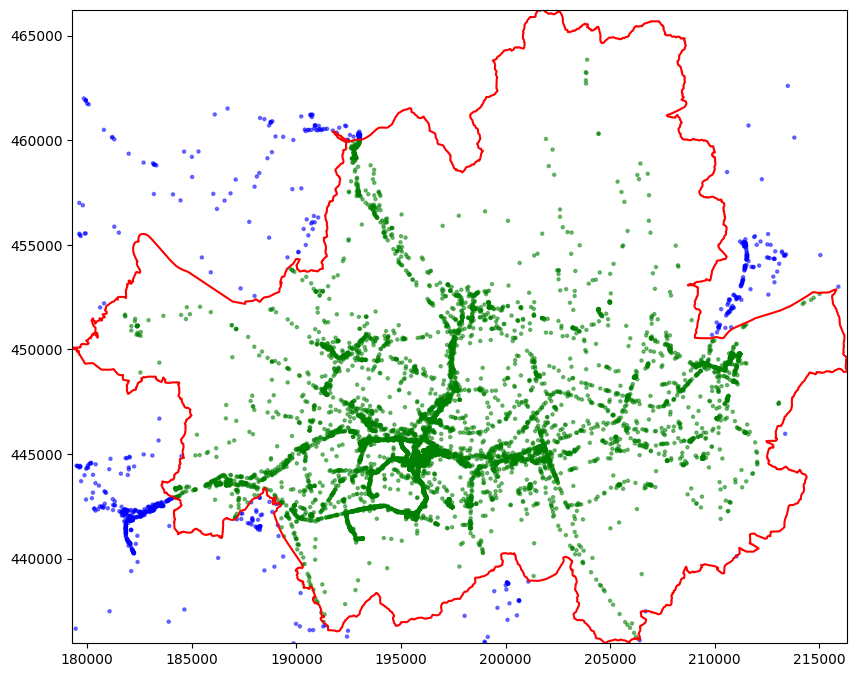

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))
extents_gdf.boundary.plot(ax=ax, color='red')  # Plot extents
positions_gdf.plot(ax=ax, color='blue', alpha=0.5, markersize=5)  # Plot points
plt.show()


# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the extents
extents_gdf.boundary.plot(ax=ax, color='red')

# Plot the points with different colors based on the in_Seoul value
positions_gdf.plot(ax=ax, color=positions_gdf['in_Seoul'].map({True: 'green', False: 'blue'}), alpha=0.5, markersize=5)

# Set the plot limits to zoom in more to the extents
minx, miny, maxx, maxy = extents_gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

plt.show()

In [ ]:
# Merge the outside records into the positions
positions_seoul = positions_gdf.copy()
positions_seoul = positions_seoul[positions_seoul['in_Seoul']]

positions_seoul = pd.concat([positions_seoul, outside_records_df])
positions_seoul = positions_seoul.sort_values(by=['id_participant', 'merged_datetime'])

In [ ]:
print('Max id:', positions_seoul["node_id"].max())
print('Number of node ids:', len(positions_seoul["node_id"].unique()))

Max id: 1.0
Number of node ids: 2


In [ ]:
# Dividing the points outside Seoul into eight node IDs based on their directional quadrant:
# 1: NN, 2: NE, 3: EE, 4: SE, 5: SS, 6: SW, 7: WW, 8: NW

seoul_center = extents_gdf.union_all().centroid
center_x, center_y = seoul_center.x, seoul_center.y

def assign_cardinal_node_id(row):
    if row['node_id'] != 1:
        return row['node_id']
    
    dx = row.geometry.x - center_x  # Longitude difference
    dy = row.geometry.y - center_y  # Latitude difference

    # Angle in coordinates (0° = East, 90° = North)
    angle = np.degrees(np.arctan2(dy, dx)) 
    if angle < 0:
        angle += 360  # Convert angle to a 0-360° scale

    # Assigning node_id based on 45-degree sectors
    if 0 <= angle < 22.5 or angle >= 337.5:
        return 1  # EE (East)
    elif 22.5 <= angle < 67.5:
        return 2  # NE (North-East)
    elif 67.5 <= angle < 112.5:
        return 3  # NN (North)
    elif 112.5 <= angle < 157.5:
        return 4  # NW (North-West)
    elif 157.5 <= angle < 202.5:
        return 5  # WW (West)
    elif 202.5 <= angle < 247.5:
        return 6  # SW (South-West)
    elif 247.5 <= angle < 292.5:
        return 7  # SS (South)
    elif 292.5 <= angle < 337.5:
        return 8  # SE (South-East)

positions_seoul["node_id"] = positions_seoul.apply(assign_cardinal_node_id, axis=1)


In [ ]:
print('Max id:', positions_seoul["node_id"].max())
print('Number of node ids:', len(positions_seoul["node_id"].unique()))

Max id: 8.0
Number of node ids: 9


C:\Users\Michele\AppData\Local\Temp\ipykernel_12380\2324255775.py:32: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  wedge = Wedge(


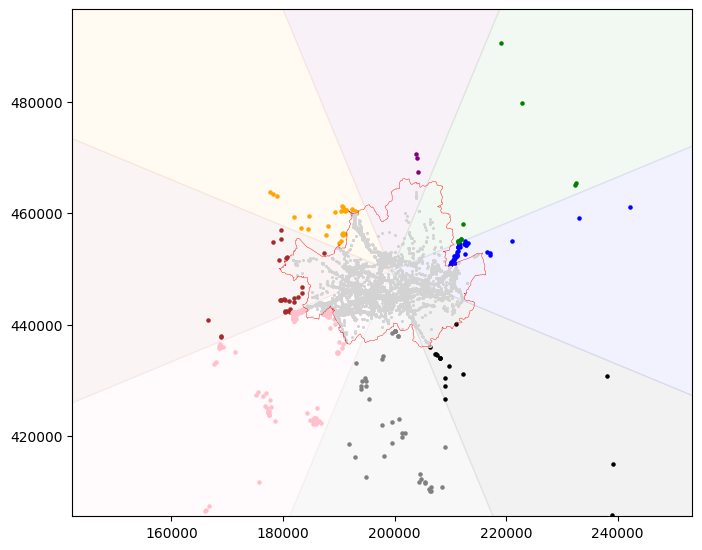

In [ ]:
from matplotlib.patches import Wedge
fig, ax = plt.subplots(figsize=(8, 8))

# Define node colors (Same as points, but will use lower opacity for background)
node_colors = {
    1: "blue",
    2: "green",
    3: "purple",
    4: "orange",
    5: "brown",
    6: "pink",
    7: "gray",
    8: "black",
}

# Get Seoul center point
seoul_center = extents_gdf.union_all().centroid
center_x, center_y = seoul_center.x, seoul_center.y

# Define max radius (adjustable based on data range)
max_radius = max(
    positions_seoul.geometry.x.max() - center_x,
    positions_seoul.geometry.y.max() - center_y
) * 1.2  # Scale up to ensure full coverage

# **Step 1: Add Transparent Background Slices**
for node_id, color in node_colors.items():
    start_angle = (node_id - 1) * 45 - 22.5  # Each slice is 45 degrees
    end_angle = node_id * 45 - 22.5

    # Add the Wedge (Pie Slice) to represent the quadrant
    wedge = Wedge(
        (center_x, center_y), max_radius, start_angle, end_angle,
        color=color, alpha=0.05, edgecolor="none", label=f"Quadrant {node_id}"
    )
    ax.add_patch(wedge)

# **Step 2: Overlay Points with Full Opacity**
for node_id, color in node_colors.items():
    positions_seoul[positions_seoul["node_id"] == node_id].plot(
        ax=ax, color=color, markersize=5, label=f"Node {node_id}"
    )

# Plot Seoul boundary
extents_gdf.boundary.plot(ax=ax, color='red', linewidth=0.3, label="Seoul Extents")

# Plot NaN node_id points in light grey
positions_seoul[positions_seoul["in_Seoul"]].plot(ax=ax, color='lightgrey', markersize=1.5, label="Unknown (NaN)")

# **Step 3: Adjust Map Limits**
minx, miny, maxx, maxy = extents_gdf.total_bounds
x_margin = (maxx - minx) * 1
y_margin = (maxy - miny) * 1

ax.set_xlim(minx - x_margin, maxx + x_margin)
ax.set_ylim(miny - y_margin, maxy + y_margin)

# **Step 4: Final Adjustments**
#plt.legend()
plt.gca().set_aspect('equal')  # Keep the proportions correct
plt.show()

In [ ]:
print('Max id:', positions_seoul["node_id"].max())
print('Number of node ids:', len(positions_seoul["node_id"].unique()))

Max id: 8.0
Number of node ids: 9


In [ ]:
# manually fixing a location with a wrong value

target_timestamp = "2023-11-15 10:13:59.690000+09:00"
target_participant = 'arda21'

matching_records = positions_seoul[
    (positions_seoul["id_participant"] == target_participant) &
    (positions_seoul["timestamp"] == target_timestamp)
]

if len(matching_records) == 1:
    # Modify the location attribute (set to NaN or another value)
    positions_seoul.loc[
        (positions_seoul["id_participant"] == target_participant) &
        (positions_seoul["timestamp"] == target_timestamp),
        "location"
    ] = np.nan

In [ ]:
print('Max id:', positions_seoul["node_id"].max())
print('Number of node ids:', len(positions_seoul["node_id"].unique()))

Max id: 8.0
Number of node ids: 9


In [ ]:
home_locations = positions_seoul[(positions_seoul['in_Seoul']) & (positions_seoul['location'] == 'Home')]

home_node_mapping = {}  # dictionary to track home node IDs

max_existing_node_id = positions_seoul['node_id'].max()


for participant_id in home_locations['id_participant'].unique():        # assigning a unique node_id for each participant's home location
    if participant_id in ['arda17']:                                    # skip participant 17 (they have 2 homes)
        continue
    max_existing_node_id += 1 
    home_node_mapping[participant_id] = max_existing_node_id

# assigning the correct home node_id to each home location
def assign_home_node_id(row):
    if row['id_participant'] in home_node_mapping and row['location'] == 'Home' and row['in_Seoul']:
        return home_node_mapping[row['id_participant']]
    return row['node_id']  # Keep existing node_id if not a home location

positions_seoul['node_id'] = positions_seoul.apply(assign_home_node_id, axis=1)

# assinging two home nodes for participant 17 (using a latitude threshold)
max_existing_node_id += 1 
positions_seoul.loc[
    (positions_seoul["id_participant"] == 17) &
    (positions_seoul["location"] == "home") &
    (positions_seoul["latitude"] >= 37.53),
    "node_id"
] = max_existing_node_id # First home node_id

max_existing_node_id += 1 
positions_seoul.loc[
    (positions_seoul["id_participant"] == 17) &
    (positions_seoul["location"] == "home") &
    (positions_seoul["latitude"] < 37.53),
    "node_id"
] = max_existing_node_id # Second home node_id


# ensuring node_id is integer
positions_seoul['node_id'] = positions_seoul['node_id'].fillna(0).astype(int)

print('Home node assignments:', home_node_mapping)
print(positions_seoul['node_id'].value_counts())
print(max_existing_node_id)

Home node assignments: {'arda01': np.float64(9.0), 'arda02': np.float64(10.0), 'arda03': np.float64(11.0), 'arda04': np.float64(12.0), 'arda05': np.float64(13.0), 'arda07': np.float64(14.0), 'arda08': np.float64(15.0), 'arda09': np.float64(16.0), 'arda10': np.float64(17.0), 'arda11': np.float64(18.0), 'arda12': np.float64(19.0), 'arda13': np.float64(20.0), 'arda14': np.float64(21.0), 'arda15': np.float64(22.0), 'arda16': np.float64(23.0), 'arda18': np.float64(24.0), 'arda19': np.float64(25.0), 'arda20': np.float64(26.0), 'arda21': np.float64(27.0), 'arda22': np.float64(28.0)}
node_id
0     12410
6       258
7       172
4       119
1        71
8        67
17       52
12       41
14       39
19       34
5        27
16       22
15       19
27       19
2        16
23       16
18       15
24       13
20       11
10       11
13       11
22       11
9         9
25        7
26        7
11        5
3         3
28        3
21        1
Name: count, dtype: int64
30.0


In [ ]:
print('Max id:', positions_seoul["node_id"].max())
print('Number of node ids:', len(positions_seoul["node_id"].unique()))

Max id: 28
Number of node ids: 29


In [ ]:
# using the survey start time as the datetime value for home locations
# since there is occasionally some large delay between the survey and location timestamps

positions_seoul['ws_timestamp_start'] = pd.to_datetime(positions_seoul['ws_timestamp_start'], errors='coerce')

positions_seoul.loc[
    (positions_seoul['location'] == 'Home') & (positions_seoul['in_Seoul']),
    'merged_datetime'
] = positions_seoul['ws_timestamp_start']


In [ ]:
# getting the building id for points inside a building 
positions_seoul.set_crs(buildings.crs, inplace=True)

positions_seoul["building_id"] = gpd.sjoin(
    positions_seoul, 
    buildings[['geometry', 'BD_MGT_SN']], 
    how='left', 
    predicate='within'
    )["BD_MGT_SN"].values

print(buildings.crs)

positions_seoul.loc[positions_seoul["q_location"] == "Outdoors", "building_id"] = np.nan

EPSG:5174


In [ ]:
# assigning closest building id to 'Indoors' records that fall outside a building

filtered_positions = positions_seoul[
    (positions_seoul['building_id'].isna()) &
    (positions_seoul['q_location'] == 'Indoors')
].copy()

buildings_tree = STRtree(buildings.geometry)                        # spatial index for buildings for faster lookup

matched_building_ids = buildings['BD_MGT_SN'].iloc[                 # find the nearest building for each point and its BD_MGT_SN id
    buildings_tree.nearest(filtered_positions.geometry.values)
].values

filtered_positions["building_id"] = matched_building_ids            # assign the building id to the filtered positions

positions_seoul.update(filtered_positions)                          # update the original positions dataframe

In [ ]:
# assigning the same building id to records where no change in location is indicated

# survey rows where the location is indoors and no location change is indicated
for participant_id, group in positions_seoul.groupby("id_participant"):
    last_building_id = None
    last_indoor_point = None
    last_indoor_time = None

    for idx, row in group.iterrows():
        if pd.notna(row['q_location']) and row['q_location'] == 'Indoors':
            if row['q_location_change'] == 'No, I did not change location' and last_building_id is not None:
                time_diff = (row['merged_datetime'] - last_indoor_time).total_seconds() / 3600
                distance = row['geometry'].distance(last_indoor_point)

                if time_diff < 1 and distance < 50:  # only assign same building if time and distance conditions are met
                    positions_seoul.at[idx, 'building_id'] = last_building_id
    
    if pd.notna(row['building_id']):
        last_building_id = row['building_id']
        last_indoor_point = row['geometry']
        last_indoor_time = row['merged_datetime']

    # other rows between survey rows with no change in location
    elif pd.isna(row['q_location']):
        if last_building_id is not None:
            time_diff = (row['merged_datetime'] - last_indoor_time).total_seconds() / 3600
            distance = row['geometry'].distance(last_indoor_point)

            if time_diff < 1 and distance < 50:  # only assign same building if time and distance conditions are met
                positions_seoul.at[idx, 'building_id'] = last_building_id

In [ ]:
print('Max id:', positions_seoul["node_id"].max())
print('Number of node ids:', len(positions_seoul["node_id"].unique()))

Max id: 28
Number of node ids: 29


In [ ]:
# giving a unique node_id to rows that have the same building id
max_existing_node_id = positions_seoul["node_id"].max()

building_points = positions_seoul[(positions_seoul["building_id"].notna()) & (positions_seoul["node_id"] == 0)].copy()

unique_buildings = building_points["building_id"].unique()
building_id_to_node_id = {bid: max_existing_node_id + i + 1 for i, bid in enumerate(unique_buildings)}

building_points["node_id"] = building_points["building_id"].map(building_id_to_node_id)

positions_seoul.update(building_points)

In [521]:
print('Max id:', positions_seoul["node_id"].max())
print('Number of node ids:', len(positions_seoul["node_id"].unique()))

Max id: 916
Number of node ids: 917


In [522]:
# clustering the remaining points (outdoors) using HDBSCAN
import hdbscan

remaining_points = positions_seoul[positions_seoul["node_id"] == 0].copy()
coords = np.array(list(zip(remaining_points.geometry.x, remaining_points.geometry.y))) # converting coordinates to numpy array for faster processing

# running HDBSCAN
min_cluster_size = 5       # 8
min_samples = 3            # 5
clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, metric='euclidean')
cluster_labels = clusterer.fit_predict(coords)

# normalize cluster labels to consecutive ids
max_existing_node_id = positions_seoul["node_id"].max()

unique_cluster_labels = np.unique(cluster_labels[cluster_labels != -1])  # Ignore noise (-1)
label_map = {label: max_existing_node_id + 1 + i for i, label in enumerate(unique_cluster_labels)}
print("Number of clusters:", len(unique_cluster_labels))

# assigning the same node_id to all points in a cluster
clustered_points_mask = cluster_labels != -1
remaining_points.loc[clustered_points_mask, "node_id"] = [label_map[label] for label in cluster_labels[clustered_points_mask]]
print("Number of clustered points:", clustered_points_mask.sum())

# assigning node_ids to the points that are not part of any cluster
alone_points_mask = cluster_labels == -1
print("Number of unclustered points:", alone_points_mask.sum())

if alone_points_mask.sum() > 0:
    max_existing_node_id = max(positions_seoul["node_id"].max(), remaining_points["node_id"].max())

    alone_points_ids = np.arange(
        max_existing_node_id + 1,
        max_existing_node_id + 1 + alone_points_mask.sum()
    )

    remaining_points.loc[alone_points_mask, "node_id"] = alone_points_ids

positions_seoul.update(remaining_points)

#remaining_points.to_file(os.path.join(base_dir,"shapefiles/nodes_outside/HDBSCAN_8_5.shp"))

d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Number of clusters: 560
Number of clustered points: 6464
Number of unclustered points: 2298


In [523]:
print('Max id:', remaining_points["node_id"].max())
print('Number of node ids:', len(remaining_points["node_id"].unique()))

print('Max id:', positions_seoul["node_id"].max())
print('Number of node ids:', len(positions_seoul["node_id"].unique()))

Max id: 3774
Number of node ids: 2858
Max id: 3774
Number of node ids: 3774


In [524]:
print('Max id:', remaining_points["node_id"].max())
print('Number of node ids:', len(remaining_points["node_id"].unique()))

print('Max id:', positions_seoul["node_id"].max())
print('Number of node ids:', len(positions_seoul["node_id"].unique()))

Max id: 3774
Number of node ids: 2858
Max id: 3774
Number of node ids: 3774


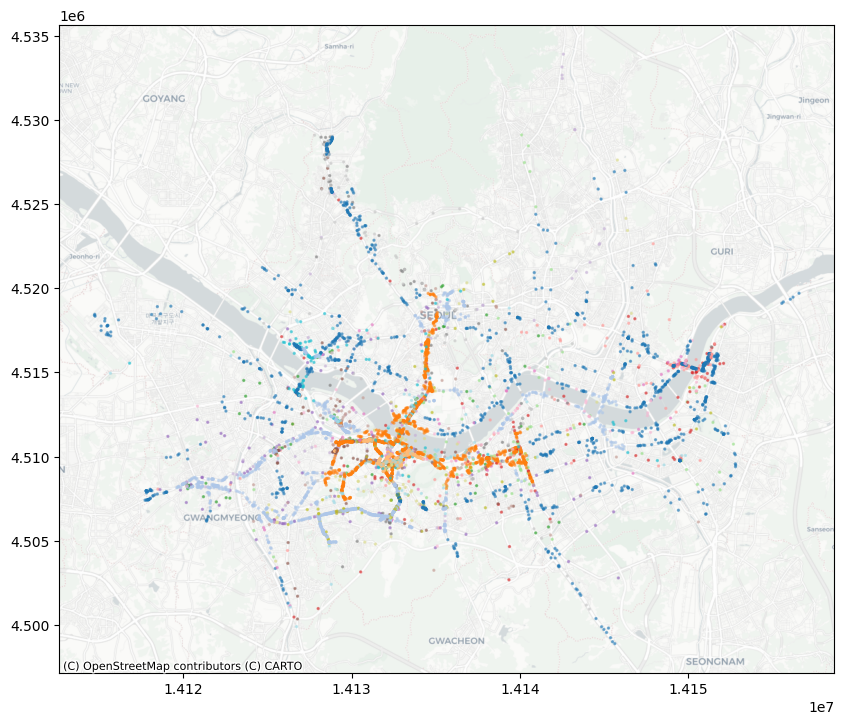

In [525]:
import contextily as cx

remaining_points_plot = remaining_points[remaining_points['in_Seoul']].copy()
remaining_points_plot.to_crs(epsg=3857, inplace=True)

ax = remaining_points_plot.plot(
    figsize=(10, 10), 
    column='node_id',
    cmap='tab20',
    alpha=0.5, 
    markersize=2, 
    )

cx.add_basemap(ax, zoom=12, source=cx.providers.CartoDB.Positron)


In [526]:
# creating node coordinates by taking the median coordinates from positions with the same node id

node_coords = positions_seoul.groupby("node_id").agg(
    node_x=("geometry", lambda g: np.median(g.x)),
    node_y=("geometry", lambda g: np.median(g.y))
).reset_index()
# now positions_seoul has node coords for each node_i

In [527]:
print('Max id:', positions_seoul["node_id"].max())
print('Number of node ids:', len(positions_seoul["node_id"].unique()))

Max id: 3774
Number of node ids: 3774


In [528]:
# manually setting the cardinal nodes' coordinates
max_distance = extents_gdf.boundary.distance(seoul_center).max()
print(max_distance)

offset_factor = 2.3
outer_radius = max_distance * offset_factor

angles = np.deg2rad([0, 45, 90, 135, 180, 225, 270, 315])  # NN, NE, EE, SE, SS, SW, WW, NW

# computing new positions for nodes 1-8
for node_id, angle in zip(range(1, 9), angles):
    node_coords.loc[node_coords["node_id"] == node_id, ["node_x", "node_y"]] = [
        seoul_center.x + outer_radius * np.cos(angle),
        seoul_center.y + outer_radius * np.sin(angle)
    ]

positions_seoul = positions_seoul.drop(columns=["node_x", "node_y"], errors="ignore")

positions_seoul = positions_seoul.merge(node_coords, on="node_id", how="left")

8922.561788188614


In [529]:
print('Max id:', positions_seoul["node_id"].max())
print('Number of node ids:', len(positions_seoul["node_id"].unique()))

Max id: 3774
Number of node ids: 3774


In [530]:
# creating a node gdf with the node coordinates and id
nodes = gpd.GeoDataFrame(
    node_coords,
    geometry=[Point(x,y) for x, y in zip(node_coords["node_x"], node_coords["node_y"])],
    crs=positions_seoul.crs
)

nodes = nodes.merge(positions_seoul[['node_id', 'building_id']].drop_duplicates(subset=['node_id']), on='node_id', how='left')
nodes["Indoors"] = nodes["building_id"].notna()
nodes.drop(columns=["building_id"], inplace=True)

nodes['in_Seoul'] = ~nodes['node_id'].between(1, 8)  # marking the cardinal nodes as outside Seoul

In [531]:
#updating the speed field
positions_seoul['prev_lat'] = positions_seoul.groupby('id_participant')['latitude'].shift()
positions_seoul['prev_lon'] = positions_seoul.groupby('id_participant')['longitude'].shift()
positions_seoul['prev_time'] = positions_seoul.groupby('id_participant')['merged_datetime'].shift()
positions_seoul['time_diff'] = (positions_seoul['merged_datetime'] - positions_seoul['prev_time']).dt.total_seconds()
positions_seoul['geo_distance'] = positions_seoul.apply(
    lambda row: geodesic((row['latitude'], row['longitude']), 
                         (row['prev_lat'], row['prev_lon'])
                        ).meters if pd.notnull(row['prev_lat']) and pd.notnull(row['prev_lon']) else 0,
    axis=1
)
positions_seoul['speed'] = positions_seoul['geo_distance'] / positions_seoul['time_diff']

# set nan speed values to 0
positions_seoul['speed'].fillna(0, inplace=True)

C:\Users\Michele\AppData\Local\Temp\ipykernel_12380\2239816831.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  positions_seoul['speed'].fillna(0, inplace=True)


In [532]:
positions_links = positions_seoul[['id_participant','merged_datetime', 'node_id', 'speed']].copy()

#positions_links['prev_node_id'] = positions_links.groupby('id_participant')['node_id'].shift()
#positions_links['prev_node_id'] = positions_links['prev_node_id'].fillna(0).astype(int)
#positions_links['prev_node_id'] = positions_links['prev_node_id'].astype(int)

positions_links['node_id'] = positions_links['node_id'].astype(int)
positions_links['prev_node_id'] = positions_links.groupby('id_participant')['node_id'].shift(1)
positions_links = positions_links.dropna(subset=['prev_node_id'])
positions_links['prev_node_id'] = positions_links['prev_node_id'].astype(int)

positions_links['id_participant'] = positions_links["id_participant"].str.extract(r'arda(\d+)').astype(int)

In [533]:
nodes.to_file(os.path.join(base_dir,"shapefiles/_network_parts_1/nodes.shp"))
nodes.to_csv(os.path.join(base_dir,"shapefiles/_network_parts_1/nodes.csv"))


positions_links.to_csv(os.path.join(base_dir,"shapefiles/_network_parts_1/positions_links.csv"))

In [93]:
# Create a flag column for different conditions
# 1 - Indoors  & Inside Building
# 2 - Indoors & Outside Building
# 3 - Not Indoors & Inside Building
# 4 - Not Indoors & Outside Building

def assign_flag(row):
    indoors = row["q_location"] == "Indoors"
    outdoors = row["q_location"] == "Outdoors"
    has_building = pd.notna(row["building_id"])
    if indoors and has_building:
        return 'Indoors & Inside Building'
    elif indoors and not has_building:
        return 'Indoors & Outside Building'
    elif outdoors and has_building:
        return 'Outdoors & Inside Building'
    elif outdoors and not has_building:
        return 'Outdoors & Outside Building'
    elif pd.isna(row["q_location"]) and has_building:
        return 'Unknown & Inside Building'  
    elif pd.isna(row["q_location"]) and not has_building:
        return 'Unknown & Outside Building'

positions_seoul["location_flag"] = positions_seoul.apply(assign_flag, axis=1)

#output positions_soeul to a gejson
output_geojson = os.path.join(base_dir, "positions.geojson")
positions_seoul.to_file(output_geojson, driver='GeoJSON')


# __Some Data and Graphs about the Dataset__

Number of entries taken between 18:00 and 09:00: 5371
Number of entries taken between 18:00 and 09:00: 5371
Percentage of entries taken between 18:00 and 09:00: 39.01%
0.4583333333333333


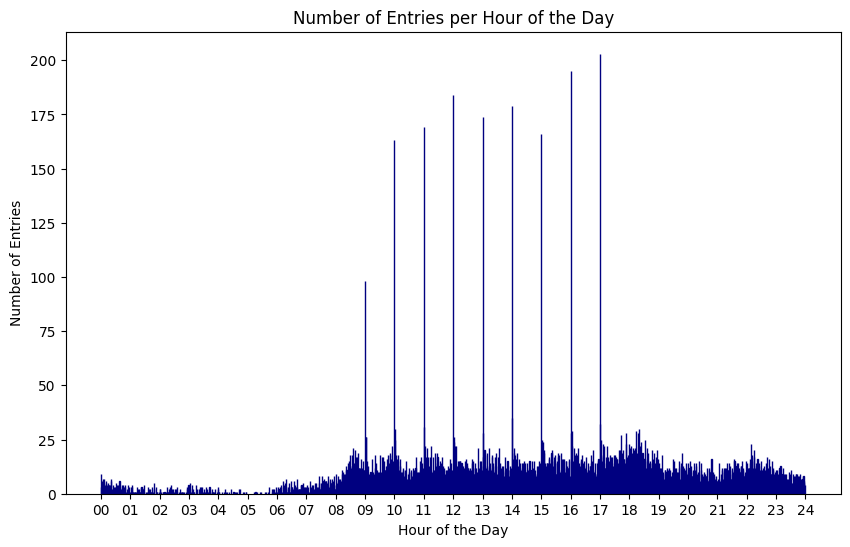

In [ ]:
non_redundant_df['time'] = non_redundant_df['merged_datetime'].dt.time
start_time = pd.to_datetime('18:00:00').time()
end_time = pd.to_datetime('09:00:00').time()

evening_entries = non_redundant_df[(non_redundant_df['time'] >= start_time)]
morning_entries = non_redundant_df[(non_redundant_df['time'] <= end_time)]

night_entries = pd.concat([evening_entries, morning_entries])

num_night_entries = len(night_entries)
total_entries = len(non_redundant_df)


print(f"Number of entries taken between 18:00 and 09:00: {num_night_entries}")
print(f"Number of entries taken between 18:00 and 09:00: {num_night_entries}")
print(f"Percentage of entries taken between 18:00 and 09:00: {(num_night_entries / total_entries) * 100:.2f}%")
print(11/24)


non_redundant_df['minutes_since_midnight'] = non_redundant_df['merged_datetime'].dt.hour * 60 + non_redundant_df['merged_datetime'].dt.minute

# Create a histogram of the minute values
plt.figure(figsize=(10, 6))
plt.hist(non_redundant_df['minutes_since_midnight'], bins=1440, range=(0, 1440), edgecolor='navy', width=0.1)
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Entries')
plt.title('Number of Entries per Hour of the Day')
plt.xticks(range(0, 24))
plt.grid(axis='y')

# Format the x-axis labels to show time in HH:MM format
def format_time(x, pos):
    hours = int(x // 60)
    minutes = int(x % 60)
    return f'{hours:02d}'

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_time))
plt.xticks(range(0, 1441, 60))  # Set x-ticks every hour
plt.grid(axis='y')

# Show the plot
plt.show()




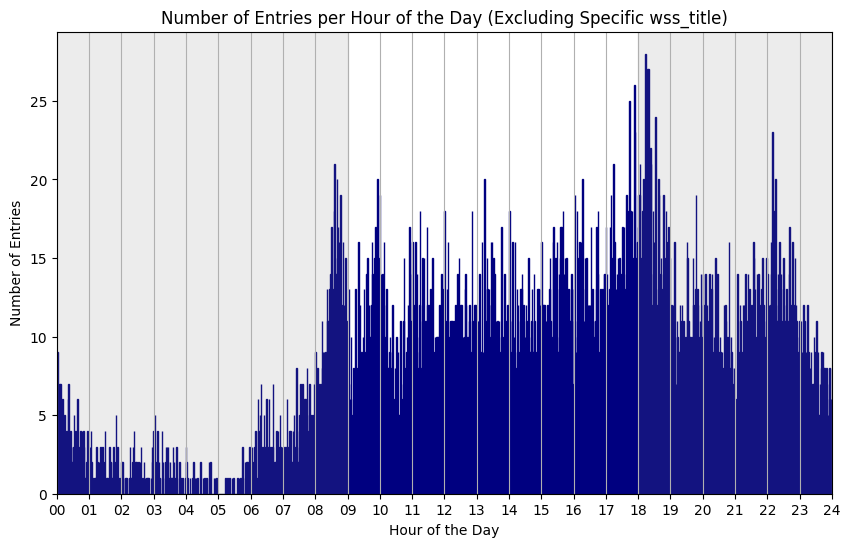

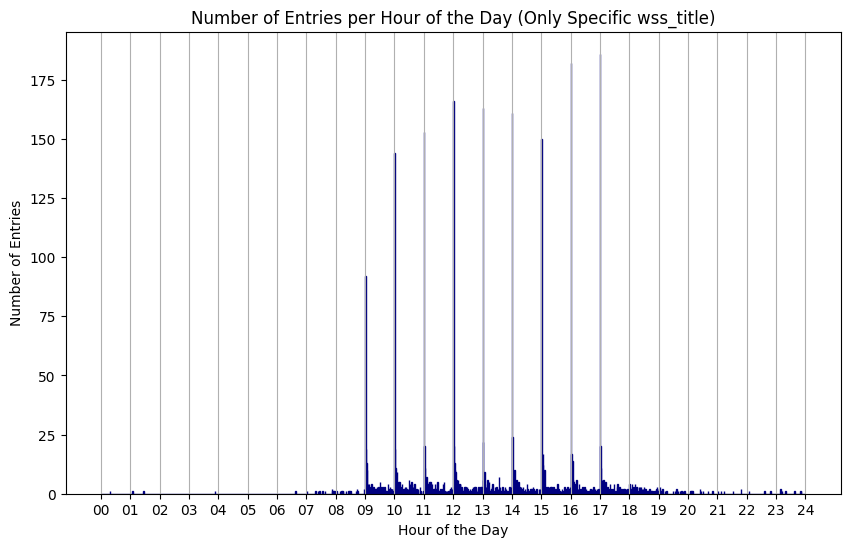

In [ ]:
# Filter the DataFrame to exclude entries with wss_title as "Arda survey - Korean" or "Arda survey - English"
filtered_df_exclude = non_redundant_df[~non_redundant_df['wss_title'].isin(['Arda survey - Korean', 'Arda survey - English'])]

# Create a histogram of the minute values for the filtered dataset (excluding specific wss_title)
plt.figure(figsize=(10, 6))
plt.hist(filtered_df_exclude['minutes_since_midnight'], bins=1440, range=(0, 1440), edgecolor='navy')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Entries')
plt.title('Number of Entries per Hour of the Day (Excluding Specific wss_title)')
plt.xticks(range(0, 1441, 60))  # Set x-ticks every hour
plt.grid(axis='x')
plt.xlim(0, 1440)

plt.axvspan(18 * 60, 24 * 60, color='grey', alpha=0.15)
plt.axvspan(0, 9 * 60, color='grey', alpha=0.15)

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_time))
plt.show()

# Filter the DataFrame to include only entries with wss_title as "Arda survey - Korean" or "Arda survey - English"
filtered_df_include = non_redundant_df[non_redundant_df['wss_title'].isin(['Arda survey - Korean', 'Arda survey - English'])]

# Create a histogram of the minute values for the filtered dataset (including only specific wss_title)
plt.figure(figsize=(10, 6))
plt.hist(filtered_df_include['minutes_since_midnight'], bins=1440, range=(0, 1440), edgecolor='navy')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Entries')
plt.title('Number of Entries per Hour of the Day (Only Specific wss_title)')
plt.xticks(range(0, 1441, 60))  # Set x-ticks every hour
plt.grid(axis='x')

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_time))
plt.show()

# __Exporting Shapefiles of Cleaned Data__

In [50]:
# making shapefiles: polylines and points for each participant
# ALL RECORDS

cozie_df = cozie_df.sort_values(by=['id_participant', 'merged_datetime'])

output_dir_paths = os.path.join(base_dir,"shapefiles/paths")
output_dir_points = os.path.join(base_dir,"shapefiles/points")

os.makedirs(output_dir_paths, exist_ok=True)
os.makedirs(output_dir_points, exist_ok=True)
participants = cozie_df['id_participant'].unique()

for participant in participants:
    participant_df = cozie_df[cozie_df['id_participant'] == participant]

    # 1: creating a polyline for each day
    polylines = []
    for date, group in participant_df.groupby('date'):
        points = [Point(xy) for xy in zip(group['longitude'], group['latitude'])]
        if len(points) > 1:
            polyline = LineString(points)
            polylines.append({'geometry': polyline, 'date': date})
    
    if polylines:
        polylines_gdf = gpd.GeoDataFrame(polylines)
        polylines_gdf.set_crs(epsg=4326, inplace=True)
        polylines_gdf.to_file(os.path.join(output_dir_paths, f"participant_{participant}_polylines.shp"))
    
    # 2: creating points with day attribute
    points = gpd.GeoDataFrame(participant_df, geometry=[Point(xy) for xy in zip(participant_df['longitude'], participant_df['latitude'])])
    points = points.select_dtypes(exclude=['timedelta64'])
    points.set_crs(epsg=4326, inplace=True)
    points.to_file(os.path.join(output_dir_points, f"participant_{participant}_points.shp"))



C:\Users\Michele\AppData\Local\Temp\ipykernel_26192\3709459755.py:33: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  points.to_file(os.path.join(output_dir_points, f"participant_{participant}_points.shp"))
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'id_participant' to 'id_partici'
  ogr_write(
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'location_change' to 'location_c'
  ogr_write(
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'q_activity_change_leisure' to 'q_activity'
  ogr_write(
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'q_activity_change_meal' to 'q_activi_1'
  ogr_write(
d:\Desk

In [ ]:
# making shapefiles: polylines and points for each participant
# NON-REDUNDANT RECORDS

non_redundant_df = non_redundant_df.sort_values(by=['id_participant', 'merged_datetime'])

output_dir_paths_non_redundant = os.path.join(base_dir,f"shapefiles/paths_non_redundant_{time_threshold.seconds}")
output_dir_points_non_redundant = os.path.join(base_dir,f"shapefiles/points_non_redundant_{time_threshold.seconds}")

os.makedirs(output_dir_paths_non_redundant, exist_ok=True)
os.makedirs(output_dir_points_non_redundant, exist_ok=True)
participants = non_redundant_df['id_participant'].unique()

for participant in participants:
    participant_df = non_redundant_df[non_redundant_df['id_participant'] == participant]

    # 1: creating a polyline for each day
    polylines = []
    for date, group in participant_df.groupby('date'):
        points = [Point(xy) for xy in zip(group['longitude'], group['latitude'])]
        if len(points) > 1:
            polyline = LineString(points)
            polylines.append({'geometry': polyline, 'date': date})
    
    if polylines:
        polylines_gdf = gpd.GeoDataFrame(polylines)
        polylines_gdf.set_crs(epsg=4326, inplace=True)
        polylines_gdf.to_file(os.path.join(output_dir_paths_non_redundant, f"participant_{participant}_polylines.shp"))
    
    # 2: creating points with day attribute
    points = gpd.GeoDataFrame(participant_df, geometry=[Point(xy) for xy in zip(participant_df['longitude'], participant_df['latitude'])])
    points = points.select_dtypes(exclude=['timedelta64'])
    points.set_crs(epsg=4326, inplace=True)
    points.to_file(os.path.join(output_dir_points_non_redundant, f"participant_{participant}_points.shp"))



C:\Users\Michele\AppData\Local\Temp\ipykernel_12352\2745704966.py:33: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  points.to_file(os.path.join(output_dir_points_non_redundant, f"participant_{participant}_points.shp"))
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'id_participant' to 'id_partici'
  ogr_write(
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'location_change' to 'location_c'
  ogr_write(
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'q_activity_change_leisure' to 'q_activity'
  ogr_write(
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'q_activity_change_meal' to 'q_activi_1'
  ogr_

In [ ]:
# making shapefiles: polylines and points for each participant
# FILTERED RECORDS

filtered_df = filtered_df.sort_values(by=['id_participant', 'merged_datetime'])

output_dir_paths_filtered = os.path.join(base_dir, f"shapefiles/paths_filtered")
output_dir_points_filtered = os.path.join(base_dir, f"shapefiles/points_filtered")


os.makedirs(output_dir_paths_filtered, exist_ok=True)
os.makedirs(output_dir_points_filtered, exist_ok=True)
participants = filtered_df['id_participant'].unique()

for participant in participants:
    participant_df = filtered_df[filtered_df['id_participant'] == participant]

    # 1: creating a polyline for each day
    polylines = []
    for date, group in participant_df.groupby('date'):
        points = [Point(xy) for xy in zip(group['longitude'], group['latitude'])]
        if len(points) > 1:
            polyline = LineString(points)
            polylines.append({'geometry': polyline, 'date': date})
    
    if polylines:
        polylines_gdf = gpd.GeoDataFrame(polylines)
        polylines_gdf.set_crs(epsg=4326, inplace=True)
        polylines_gdf.to_file(os.path.join(output_dir_paths_filtered, f"participant_{participant}_polylines.shp"))
    
    # 2: creating points with day attribute
    points = gpd.GeoDataFrame(participant_df, geometry=[Point(xy) for xy in zip(participant_df['longitude'], participant_df['latitude'])])
    points = points.select_dtypes(exclude=['timedelta64'])
    points.set_crs(epsg=4326, inplace=True)
    points.to_file(os.path.join(output_dir_points_filtered, f"participant_{participant}_points.shp"))


C:\Users\Michele\AppData\Local\Temp\ipykernel_12352\4289845932.py:33: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  points.to_file(os.path.join(output_dir_points_filtered, f"participant_{participant}_points.shp"))
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'id_participant' to 'id_partici'
  ogr_write(
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'location_change' to 'location_c'
  ogr_write(
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'q_activity_change_leisure' to 'q_activity'
  ogr_write(
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'q_activity_change_meal' to 'q_activi_1'
  ogr_write

In [ ]:
# testing sorting chronologically using other timestamp fields
timestamp_test_df = filtered_df.copy()
timestamp_test_df['datetime_ts_location'] = pd.to_datetime(timestamp_test_df.ts_timestamp_location, format='ISO8601')
timestamp_test_df['datetime_ws_location'] = pd.to_datetime(timestamp_test_df.ws_timestamp_location, format='ISO8601')



timestamp_test_df['merged_timestamp'] = timestamp_test_df['datetime_ts_location'].combine_first(timestamp_test_df['datetime_ws_location'])
timestamp_test_df['merged_date'] = timestamp_test_df['merged_timestamp'].dt.date







timestamp_test_df = timestamp_test_df.sort_values(by=['id_participant', 'merged_timestamp'])

timestamp_test_df['location'] = timestamp_test_df[
    ['q_location_leisure', 'q_location_meal', 'q_location_other', 'q_location_studying', 'q_location_working']
].apply(lambda row: row.dropna().iloc[0] if not row.dropna().empty else None, axis=1)




# re-calculating the previous-coordinate fields
timestamp_test_df['prev_lat'] = timestamp_test_df.groupby('id_participant')['latitude'].shift()
timestamp_test_df['prev_lon'] = timestamp_test_df.groupby('id_participant')['longitude'].shift()
timestamp_test_df['prev_time'] = timestamp_test_df.groupby('id_participant')['merged_datetime'].shift()
timestamp_test_df['time_diff'] = (timestamp_test_df['merged_datetime'] - timestamp_test_df['prev_time']).dt.total_seconds()
timestamp_test_df['geo_distance'] = timestamp_test_df.apply(
    lambda row: geodesic((row['latitude'], row['longitude']), 
                         (row['prev_lat'], row['prev_lon'])
                        ).meters if pd.notnull(row['prev_lat']) and pd.notnull(row['prev_lon']) else 0,
    axis=1
)


# getting the coordinates and timestamp of next location
timestamp_test_df['next_lat'] = timestamp_test_df.groupby('id_participant')['latitude'].shift(-1)
timestamp_test_df['next_lon'] = timestamp_test_df.groupby('id_participant')['longitude'].shift(-1)
timestamp_test_df['next_time'] = timestamp_test_df.groupby('id_participant')['merged_datetime'].shift(-1)

# distance from current to next location
timestamp_test_df['next_geo_distance'] = timestamp_test_df.groupby('id_participant')['geo_distance'].shift(-1)

# distance from previous to next location
timestamp_test_df['prev_next_geo_distance'] = timestamp_test_df.apply(
    lambda row: geodesic((row['prev_lat'], row['prev_lon']),
                         (row['next_lat'], row['next_lon'])).meters
    if pd.notnull(row['prev_lat']) and pd.notnull(row['prev_lon']) and 
       pd.notnull(row['next_lat']) and pd.notnull(row['next_lon']) else 0, axis=1
)

# computing the Basic Distance Ratio between the three points (previous, current, next)

timestamp_test_df['distance_ratio'] = timestamp_test_df['prev_next_geo_distance'] / (timestamp_test_df['geo_distance'] + timestamp_test_df['next_geo_distance'])
timestamp_test_df['distance_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
timestamp_test_df['distance_ratio'].fillna(0, inplace=True)

# implementing a time-scaling factor
timestamp_test_df['next_time_diff'] = timestamp_test_df.groupby('id_participant')['time_diff'].shift(-1)
timestamp_test_df['max_time_diff'] = timestamp_test_df[['time_diff', 'next_time_diff']].max(axis=1)
timestamp_test_df['time_weight'] = 1 / (1 + np.log1p(timestamp_test_df['max_time_diff']/60)) # time weight function in minutes (not seconds)

timestamp_test_df['adjusted_distance_ratio'] = (
    timestamp_test_df['distance_ratio'] * timestamp_test_df['time_weight']
)
# making shapefiles: polylines and points for each participant
# TEST WITH DIFFERENT TIMESTAMPS RECORDS

timestamp_test_df = timestamp_test_df.sort_values(by=['id_participant', 'merged_timestamp'])

output_dir_paths_test = os.path.join(base_dir, f"shapefiles/paths_timestamp_test")
output_dir_points_test = os.path.join(base_dir, f"shapefiles/points_timestamp_test")



os.makedirs(output_dir_paths_test, exist_ok=True)
os.makedirs(output_dir_points_test, exist_ok=True)
participants = timestamp_test_df['id_participant'].unique()

for participant in participants:
    participant_df = timestamp_test_df[timestamp_test_df['id_participant'] == participant]

    # 1: creating a polyline for each day
    polylines = []
    for date, group in participant_df.groupby('merged_date'):
        points = [Point(xy) for xy in zip(group['longitude'], group['latitude'])]
        if len(points) > 1:
            polyline = LineString(points)
            polylines.append({'geometry': polyline, 'date': date})
    
    if polylines:
        polylines_gdf = gpd.GeoDataFrame(polylines)
        polylines_gdf.set_crs(epsg=4326, inplace=True)
        polylines_gdf.to_file(os.path.join(output_dir_paths_test, f"participant_{participant}_polylines.shp"))
    
    # 2: creating points with day attribute
    points = gpd.GeoDataFrame(participant_df, geometry=[Point(xy) for xy in zip(participant_df['longitude'], participant_df['latitude'])])
    points = points.select_dtypes(exclude=['timedelta64'])
    points.set_crs(epsg=4326, inplace=True)
    points.to_file(os.path.join(output_dir_points_test, f"participant_{participant}_points.shp"))


C:\Users\Michele\AppData\Local\Temp\ipykernel_12352\1712768601.py:34: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  points.to_file(os.path.join(output_dir_points_test, f"participant_{participant}_points.shp"))
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'id_participant' to 'id_partici'
  ogr_write(
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'location_change' to 'location_c'
  ogr_write(
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'q_activity_change_leisure' to 'q_activity'
  ogr_write(
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'q_activity_change_meal' to 'q_activi_1'
  ogr_write(
d:

In [51]:
# Export the filtered points to a CSV file
output_csv_filtered = os.path.join(base_dir, f"filtered_points.csv")

filtered_df.to_csv(output_csv_filtered, index=False)